In [38]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.nn import Module, Parameter
from torch import FloatTensor
from scipy import signal
import numpy as np
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from scipy import signal
import numpy as np
from pylab import *
import soundfile as sf
import matplotlib.pyplot as plt

# Declare Model

In [39]:
class FIRNN(Module):
    def __init__(self, n_input=1, n_output=1, kernel_size=80, n_channel=32):
        super(FIRNN, self).__init__()        
        self.conv_kz = kernel_size
        self.input_len = 512
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=kernel_size, stride=1)
        self.nonlinear = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.fc1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=1) 
        self.fc2 = nn.Conv1d(n_channel*2, n_channel, kernel_size=1)
        
        self.conv2 = nn.Conv1d(n_channel, n_output, kernel_size=kernel_size, stride=1)
        
        self.mlp_layer = nn.Sequential(
            self.fc1 ,
            nn.Tanh(),
            self.fc2,
        )


    def forward(self, x):
        #print(x.shape)
        bs = x.shape[0]
        
        x = F.pad(x, (self.conv_kz-1, 0)) #pad on the left side
        x = self.conv1(x)
        x1 = x
        #print(x.shape) #bs*32*512
        
        x = self.bn1(x)
        x4 = x
        x = self.nonlinear(x)
        #print(x.shape) # bs*32*512
        x2 = x

        #x = x.view(bs, -1)
        x = self.mlp_layer(x)
        #x = self.layers(x)
        #print(x.shape) #bs*32*512
        x3 = x
        
        x = F.pad(x, (self.conv_kz-1, 0))
        x = self.conv2(x)
        #print(x.shape) #bs*1*512

        return x, x1, x2, x3, x4


In [40]:
class DIIRDataSet(Dataset):
    def __init__(self, input, target, sequence_length):
        self.input = input
        self.target = target
        self._sequence_length = sequence_length
        self.input_sequence = self.wrap_to_sequences(self.input, self._sequence_length)
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.input_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'input': self.input_sequence[index, :, :]
               ,'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        print(num_sequences)
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        wrapped_data = wrapped_data.permute(0,2,1)
        print(wrapped_data.shape)
        return np.float32(wrapped_data)

    

# Load Model

In [41]:
model = FIRNN(kernel_size=80, n_channel=32)

In [42]:
model_path = './models/model_firnl_mlp_fir_preamph_ep99.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

FIRNN(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(1,))
  (nonlinear): Tanh()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (fc2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(32, 1, kernel_size=(80,), stride=(1,))
  (mlp_layer): Sequential(
    (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  )
)

## Plot waveform/ before and after mlp layer

In [43]:
train_data_dir = './data/train'
val_data_dir = './data/val'
input_name = 'ht1-input.wav'
target_name = 'ht1-target.wav'
train_sig, _ = torchaudio.load(os.path.join(train_data_dir, input_name))
val_sig, sr = torchaudio.load(os.path.join(val_data_dir, input_name))
train_target_sig, _ = torchaudio.load(os.path.join(train_data_dir, target_name))
val_target_sig, _ = torchaudio.load(os.path.join(val_data_dir, target_name))
print(sr)

44100


In [44]:
out_path = './output/target_firnl_mlp_fir_preamph.wav'
distort_sig, _ = torchaudio.load(out_path)

In [45]:
train_input_seg = train_sig[:,:44100*60]
train_target_seg = train_target_sig[:,:44100*60]
distort_seg = distort_sig[:,:44100*60]

In [46]:
distort_seg.shape

torch.Size([1, 2645504])

In [47]:
val_dataset=DIIRDataSet(train_input_seg.squeeze(0), train_target_seg.squeeze(0), 512)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, pin_memory=True, drop_last=True)

5167
torch.Size([5167, 1, 512])
5167
torch.Size([5167, 1, 512])


In [48]:
def save_audio(batch):
    #1024,512,1
    out_batch = batch.detach().cpu()
    out_batch = out_batch.squeeze(-1).flatten()
    print(out_batch.shape)
    return out_batch

In [49]:
import soundfile as sf
sample_rate = 44100
save_tensor = torch.zeros(5167,512)
conv1_tensor = torch.zeros(5167,512)
bfmlp_tensor = torch.zeros(5167,512)
afmlp_tensor = torch.zeros(5167,512)
afbn_tensor = torch.zeros(5167,512)
out_path = './output/'

with torch.no_grad():
    for i, val_batch in enumerate(val_loader):
        input_seq_batch = val_batch['input']
        predicted_output, x1, x2, x3, x4 = model(input_seq_batch)
        conv1_out = x1.detach().cpu()
        #print(conv1_out.shape) #1*32*512
        bfmlp_input = x2.detach().cpu()
        afmlp_out = x3.detach().cpu()
        afbn_out = x4.detach().cpu()
        output_tmp = predicted_output.squeeze().detach().cpu()
        #print(output_tmp.shape)
        save_tensor[i,:] = output_tmp
        conv1_tensor[i,:] = conv1_out[0, 30, :]#torch.mean(conv1_out, 1)
        bfmlp_tensor[i,:] = bfmlp_input[0, 30, :]#torch.mean(bfmlp_input, 1)
        afmlp_tensor[i,:] = afmlp_out[0, 30, :]#torch.mean(afmlp_out, 1)
        afbn_tensor[i,:] = afbn_out[0, 30, :]
    
    conv1_audio = save_audio(conv1_tensor)
    bfmlp_audio = save_audio(bfmlp_tensor)
    afmlp_audio = save_audio(afmlp_tensor)
    afbn_audio = save_audio(afbn_tensor)
    out_audio = save_audio(save_tensor)
    
    #print(conv1_audio.shape)
    #print(out_audio.shape)
    #path = os.path.join(out_path, "FIRNN_HT1_.wav")
    #print("Exporting {}".format(path))
    #sf.write(os.path.join(out_path, 'FIRNN_HT1_conv1.wav'), conv1_audio, sample_rate,'PCM_24')
    #sf.write(os.path.join(out_path, 'FIRNN_HT1_bfmlp.wav'), bfmlp_audio, sample_rate,'PCM_24')
    #sf.write(os.path.join(out_path, 'FIRNN_HT1_afmlp.wav'), afmlp_audio, sample_rate,'PCM_24')
    #sf.write(os.path.join(out_path, 'FIRNN_HT1_output.wav'), out_audio, sample_rate,'PCM_24')
    #torchaudio.save(path, out_audio, sample_rate, encoding="PCM_S", bits_per_sample=16)
   

torch.Size([2645504])
torch.Size([2645504])
torch.Size([2645504])
torch.Size([2645504])
torch.Size([2645504])


In [50]:
conv1_audio.shape

torch.Size([2645504])

In [15]:
outputaudio_path = './output/'

In [16]:
# conv1_sig, sr = torchaudio.load(os.path.join(outputaudio_path, 'FIRNN_HT1_conv1.wav'))
# bfmlp_sig, _ = torchaudio.load(os.path.join(outputaudio_path, 'FIRNN_HT1_bfmlp.wav'))
# afmlp_sig, _ = torchaudio.load(os.path.join(outputaudio_path, 'FIRNN_HT1_afmlp.wav'))
# out_sig, _ = torchaudio.load(os.path.join(outputaudio_path, 'FIRNN_HT1_output.wav'))

In [20]:
conv1_sig.shape

torch.Size([1, 2645504])

In [58]:
def plot_waveform_spectrum(waveform, sample_rate, title="Waveform and Spectrum of HT-1 distorted signal", xlim=None, ylim=None):
    
    zoomed_wave = waveform[:,44100*2:44100*2+22000].numpy()
    nch, nf = zoomed_wave.shape
    time_axis_zoom = torch.arange(0, nf) / sample_rate
    
    
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    plt.figure(figsize=(15,4))

    # plot different spectrum types:
    plt.subplot(1,3,1)
    plt.title("Waveform", fontsize=18)
    plt.plot(time_axis, waveform[0], linewidth=1)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(alpha=0.4)
    plt.ylabel('Amplitude', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.ylim(-1.2, 1.2)

    plt.subplot(1,3,2)
    plt.title("Waveform Zoom (50 ms)", fontsize=18)
    plt.plot(time_axis_zoom, zoomed_wave[0], linewidth=1)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(alpha=0.4)
    plt.ylabel('Amplitude', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    #plt.ylim(-1.2, 1.2)
    plt.xlim(0.2,0.250)


    plt.subplot(1,3,3)
    plt.title("Spectrum", fontsize=18)
    plt.magnitude_spectrum(waveform[0], Fs=sample_rate, scale='dB', color='C1')
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=18)
    plt.xlabel(r'Frequency', fontsize=18)
    plt.ylim(-200, -20)

    plt.tight_layout()
    subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.savefig('./figures/'+title+'.png', dpi=150)
    plt.show()


In [ ]:
#plot_waveform_spectrum(train_input_seg, sr, title="Waveform of input")

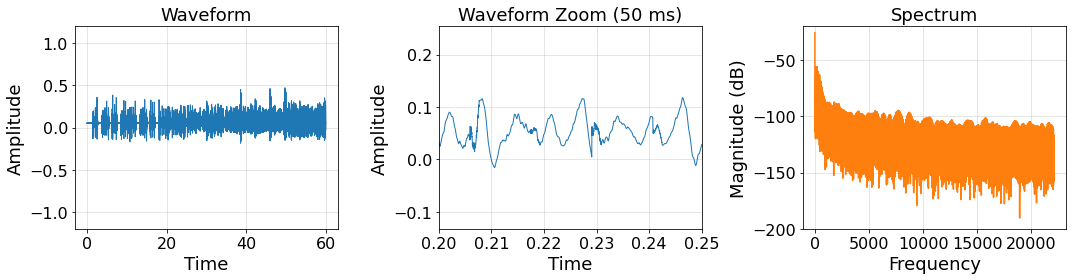

In [59]:
plot_waveform_spectrum(conv1_audio.unsqueeze(0), sr, title="Waveform after the first conv1_c30")

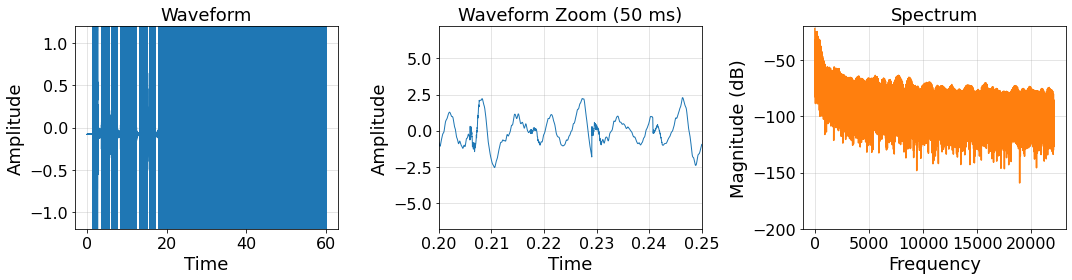

In [53]:
plot_waveform_spectrum(afbn_audio.unsqueeze(0), sr, title="Waveform after the bn_c30")

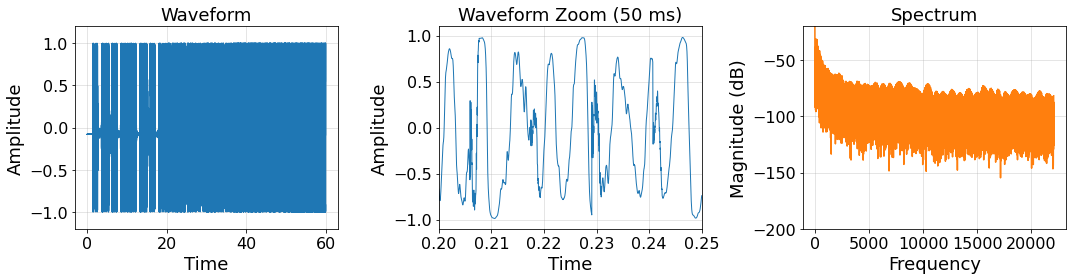

In [54]:
plot_waveform_spectrum(bfmlp_audio.unsqueeze(0), sr, title="Waveform before MLP layer_c30")
#plot_waveform(s2, sr, title="Waveform of before MLP layer")

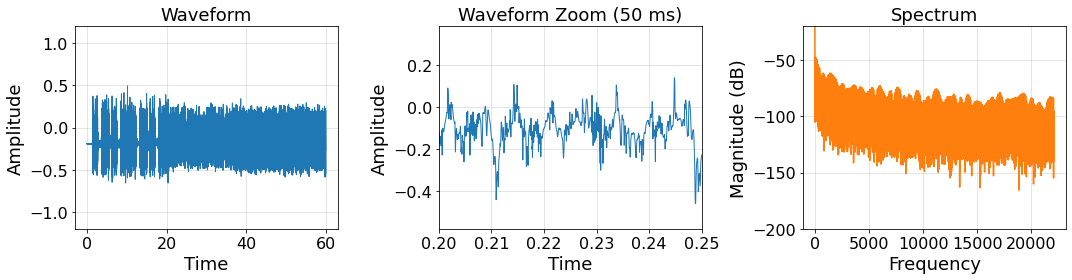

In [55]:
plot_waveform_spectrum(afmlp_audio.unsqueeze(0), sr, title="Waveform after MLP layer_c30")
#plot_waveform(s3, sr, title="Waveform of after MLP layer")

In [ ]:
#plot_waveform_spectrum(out_sig, sr, title="Waveform of the final output")

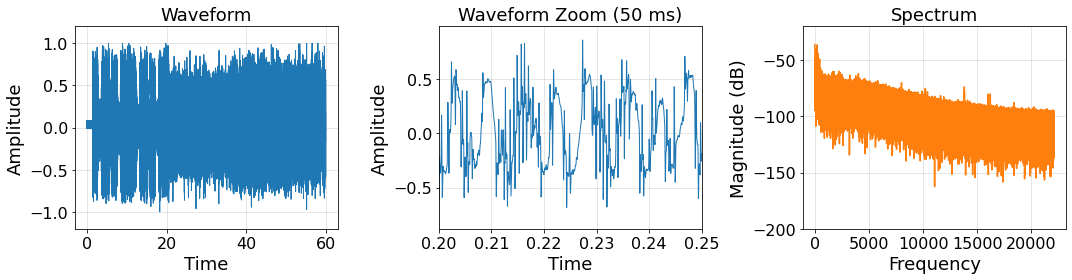

In [56]:
plot_waveform_spectrum(distort_seg, sr, title="Waveform of the final output")
#plot_waveform(s4, sr, title="Waveform of the final output")

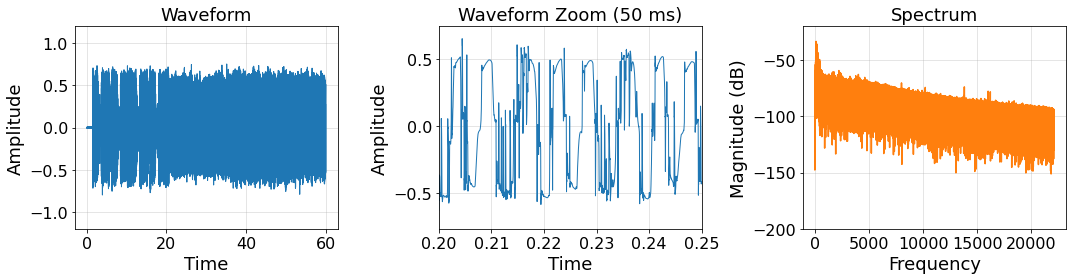

In [57]:
plot_waveform_spectrum(train_target_seg, sr, title="Waveform of the target")

In [22]:
def plot_waveform_spectrum(waveform, sample_rate, title="Waveform and Spectrum of HT-1 distorted signal", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    plt.figure(figsize=(15,4))

    # plot different spectrum types:
    plt.subplot(1,3,1)
    plt.title("Waveform", fontsize=18)
    plt.plot(time_axis, waveform[0], linewidth=1)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(alpha=0.4)
    plt.ylabel('Amplitude', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    #plt.ylim(-1.0, 1.0)

    plt.subplot(1,3,2)
    plt.title("Magnitude Spectrum", fontsize=18)
    plt.magnitude_spectrum(waveform[0], Fs=sample_rate, color='C1')
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.ylabel('Magnitude\n (energy)', fontsize=18)
    plt.xlabel(r'Frequency', fontsize=18)
    #plt.ylim(0.000, 0.035)


    plt.subplot(1,3,3)
    plt.title("Spectrum", fontsize=18)
    plt.magnitude_spectrum(waveform[0], Fs=sample_rate, scale='dB', color='C1')
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=18)
    plt.xlabel(r'Frequency', fontsize=18)
    #plt.ylim(-200, -50)

    plt.tight_layout()
    subplots_adjust(wspace=0.3)
    plt.tight_layout()
    #plt.savefig('./figures/conv1_output.png', dpi=150)
    plt.show()


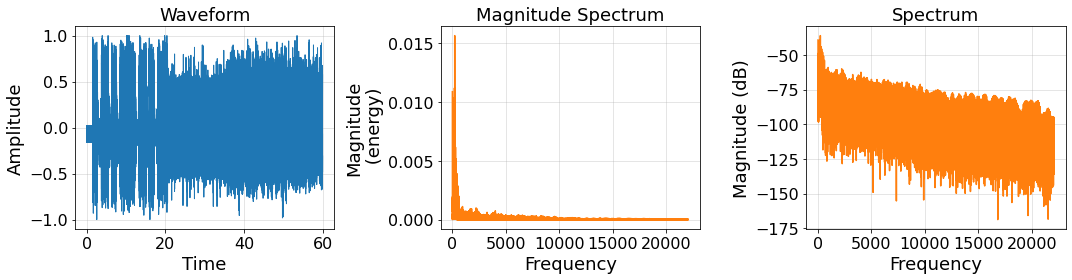

In [23]:
plot_waveform_spectrum(out_sig, sr, title="Waveform of the final output")

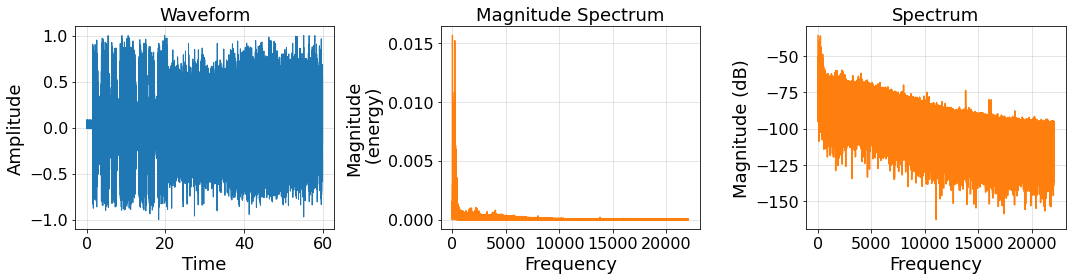

In [24]:
plot_waveform_spectrum(distort_seg, sr, title="Waveform of the final output")

In [64]:
def plot_specgram(waveform, sample_rate, title="Spectrogram of HT-1 distorted Signal", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    figure.suptitle(title, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ylabel('Frequency', fontsize=18)
    xlabel('Time', fontsize=18)
    plt.tight_layout()
    plt.savefig('./figures/'+title+'.png', dpi=150)
    plt.show(block=False)

In [65]:
train_target_seg2 = train_target_sig[:,3*44100:44100*3 + 44100*5]
distort_seg2 = distort_sig[:,3*44100:44100*3 + 44100*5]

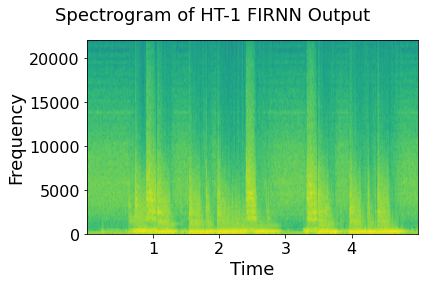

In [66]:
plot_specgram(distort_seg2, sr, title='Spectrogram of HT-1 FIRNN Output')

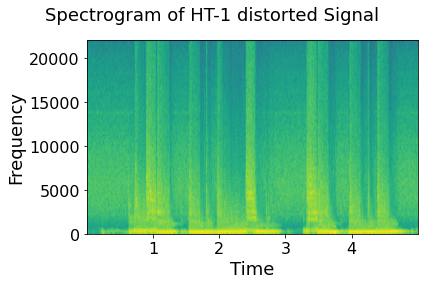

In [62]:
plot_specgram(train_target_seg2, sr, title='Spectrogram of HT-1 distorted Signal')